In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import shannon_entropy
from skimage.filters import gabor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import os
import cv2
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = "drive/MyDrive/classifier_data"

In [ ]:
normalpath = "drive/MyDrive/classifier_data/normal"
pneumopath = "drive/MyDrive/classifier_data/pneumothorax"

In [ ]:
count_normal = 0
count_pneumo = 0
for img in os.listdir(normalpath):
  count_normal += 1
for img in os.listdir(pneumopath):
  count_pneumo += 1
print(f"No. of images with no disease: {count_normal}")
print(f"No. of images with disease: {count_pneumo}")

No. of images with no disease: 6846
No. of images with disease: 2379


In [ ]:
def extract_normal(n):
  normal = []
  for img in os.listdir(normalpath):
    imgmatrix = cv2.imread(os.path.join(normalpath,img))
    normal.append(imgmatrix)
    n = n-1
    if n==0:
      return normal

In [ ]:
def extract_pneumo(n):
  pneumo = []
  for img in os.listdir(pneumopath):
    imgmatrix = cv2.imread(os.path.join(pneumopath,img))
    pneumo.append(imgmatrix)
    n = n-1
    if n==0:
      return pneumo

In [ ]:
normal = extract_normal(3)
pneumo = extract_pneumo(3)
print(type(normal))

<class 'list'>


In [ ]:
normal = np.asarray(normal)
pneumo = np.asarray(pneumo)

In [ ]:
normal.shape , pneumo.shape

((3, 256, 256, 3), (3, 256, 256, 3))

In [ ]:
normal[0]

array([[[254, 254, 254],
        [254, 254, 254],
        [247, 247, 247],
        ...,
        [248, 248, 248],
        [248, 248, 248],
        [252, 252, 252]],

       [[252, 252, 252],
        [246, 246, 246],
        [217, 217, 217],
        ...,
        [232, 232, 232],
        [237, 237, 237],
        [244, 244, 244]],

       [[244, 244, 244],
        [218, 218, 218],
        [134, 134, 134],
        ...,
        [118, 118, 118],
        [130, 130, 130],
        [152, 152, 152]],

       ...,

       [[ 50,  50,  50],
        [ 24,  24,  24],
        [ 16,  16,  16],
        ...,
        [ 13,  13,  13],
        [ 13,  13,  13],
        [ 11,  11,  11]],

       [[ 50,  50,  50],
        [ 26,  26,  26],
        [ 16,  16,  16],
        ...,
        [ 13,  13,  13],
        [ 13,  13,  13],
        [ 13,  13,  13]],

       [[ 52,  52,  52],
        [ 30,  30,  30],
        [ 18,  18,  18],
        ...,
        [ 13,  13,  13],
        [ 13,  13,  13],
        [ 13,  13,  13]]

In [ ]:
type(normal)

numpy.ndarray

In [ ]:
from google.colab.patches import cv2_imshow

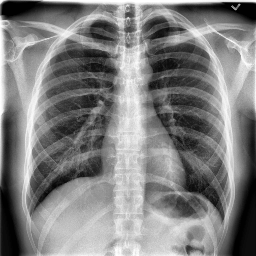

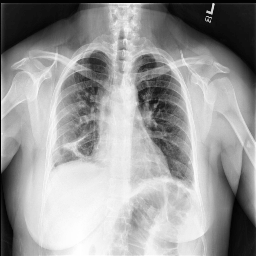

(None, None)

In [ ]:
cv2_imshow(normal[0]) , cv2_imshow(pneumo[0])

In [ ]:
# grayscale = cv2.cvtColor(pneumo[0],cv2.COLOR_BGR2GRAY)
# contrast = cv2.equalizeHist(grayscale)

# Preprocessing

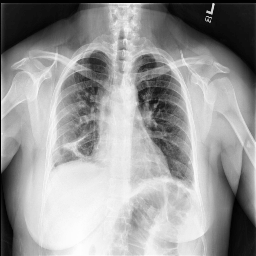

In [ ]:
#CONVERTING TO GRAYSCALE
gray = np.dot(pneumo[0],[0.2989, 0.5870, 0.1140])
cv2_imshow(gray)

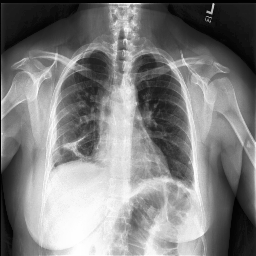

In [ ]:
#INCREASING CONTRAST USING HISTOGRAM EQUILIZATION
hist, bins = np.histogram(gray, bins=256, range=(0, 256))

#calculating cumulative distribution function (CDF)
cdf = hist.cumsum()

#normalizing CDF
cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
contrast = cdf_normalized[gray.astype('uint8')]

cv2_imshow(contrast)

In [ ]:
# medianblur = cv2.medianBlur(contrast, 3)
# cv2_imshow(contrast)
# cv2_imshow(medianblur)

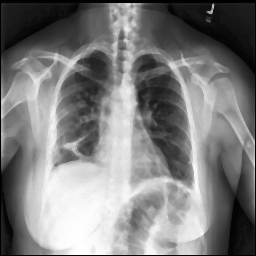

In [ ]:
#SMOOTHENING OF IMAGE USING MEDIAN FILTER
kernel_half = 3 // 2
median = np.zeros((256, 256), dtype=np.uint8)
for y in range(kernel_half, 256 - kernel_half):
      for x in range(kernel_half, 256 - kernel_half):
            kernel = contrast[y - kernel_half:y + kernel_half + 1, x - kernel_half:x + kernel_half + 1]
            median[y, x] = np.median(kernel)
cv2_imshow(median)

In [ ]:
# print(cv2.subtract(filtered_image.astype('uint8'),medianblur.astype('uint8')))

In [ ]:
#NORMALIZATION OF IMAGE MATRIX
normalized = median.astype(float) / 255.0
normalized

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01176471, 0.01176471, ..., 0.00392157, 0.00392157,
        0.        ],
       [0.        , 0.01176471, 0.01176471, ..., 0.00392157, 0.00392157,
        0.        ],
       ...,
       [0.        , 0.12941176, 0.12941176, ..., 0.11372549, 0.12156863,
        0.        ],
       [0.        , 0.13333333, 0.13333333, ..., 0.11372549, 0.12156863,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

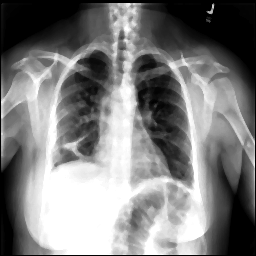

In [ ]:
window_center = 0.5
window_width = 0.8

lower_bound = (window_center - window_width / 2.0)
upper_bound = (window_center + window_width / 2.0)

windowed_image = np.clip((normalized - lower_bound) / (upper_bound - lower_bound), 0, 1)

cv2_imshow((windowed_image * 255).astype(np.uint8))

In [ ]:
# #function for preprocessing
# def preprocessing(image):
#   grayscale = cv2.cvtColor(pneumo[0],cv2.COLOR_BGR2GRAY) #grayscaling
#   contrast = cv2.equalizeHist(grayscale) #contrasting
#   medianblur = cv2.medianBlur(contrast, 3) #median filtering
#   normalized = medianblur.astype(float) / 255.0 #normalization

#   #windowing
#   window_center = 0.5
#   window_width = 0.8
#   lower_bound = (window_center - window_width / 2.0)
#   upper_bound = (window_center + window_width / 2.0)
#   windowed_image = np.clip((normalized- lower_bound) / (upper_bound - lower_bound), 0, 1)
#   return windowed_image

# # cv2_imshow((windowed_image * 255).astype(np.uint8))

In [ ]:
#function for preprocessing (without using opencv)

def preprocess_image(img):

  #converting into grayscale image
  gray = np.dot(img,[0.2989, 0.5870, 0.1140])


  #increasing contrast by histogram equalization
  hist, bins = np.histogram(gray, bins=256, range=(0, 256))
  cdf = hist.cumsum()
  cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
  contrast = cdf_normalized[gray.astype('uint8')]


  #applying median filter
  kernel_half = 3 // 2
  median = np.zeros((256, 256), dtype=np.uint8)
  for y in range(kernel_half, 256 - kernel_half):
    for x in range(kernel_half, 256 - kernel_half):
      kernel = contrast[y - kernel_half:y + kernel_half + 1, x - kernel_half:x + kernel_half + 1]
      median[y, x] = np.median(kernel)


  #normalization
  normalized = median.astype(float) / 255.0


  #windowing
  window_center = 0.5
  window_width = 1
  lower_bound = (window_center - window_width / 2.0)
  upper_bound = (window_center + window_width / 2.0)
  windowed_image = np.clip((normalized - lower_bound) / (upper_bound - lower_bound), 0, 1)


  return windowed_image

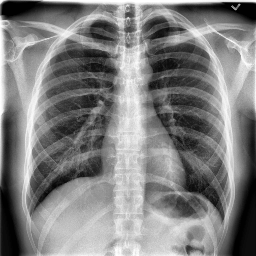

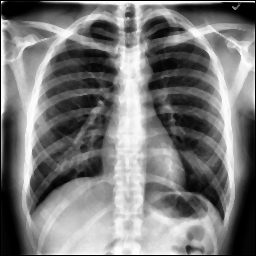

In [ ]:
cv2_imshow(normal[0])
preprocessed = (preprocess_image(normal[0])*255).astype('uint8')
cv2_imshow(preprocessed)

# Feature Extraction

In [ ]:
# # TEXTURE FEATURE EXTRACTION
# from skimage.measure import shannon_entropy
# #GLCM parameters
# distance = 1
# #0 and 45-degree angles chosen

# #gray level co-occurrence matrix
# glcm = np.zeros((256, 256), dtype=np.uint8)

# for i in range(preprocessed.shape[0] - distance):
#     for j in range(preprocessed.shape[1] - distance):
#         p = preprocessed[i, j]
#         q = preprocessed[i + distance, j + distance]
#         glcm[p, q] += 1
#         q = preprocessed[i + distance, j]
#         glcm[p, q] += 1
#         q = preprocessed[i, j + distance]
#         glcm[p, q] += 1

# # Normalizing GLCM
# glcm = glcm / glcm.sum()

# contrast = np.sum(glcm * np.square(np.arange(256) - np.mean(np.arange(256))))
# dissimilarity = np.sum(glcm * np.abs(np.arange(256) - np.mean(np.arange(256))))
# #Energy quantifies the uniformity or regularity of pixel intensities within the image patch. Higher energy values suggest more uniform textures.
# energy = np.sum(np.square(glcm))
# #Correlation measures the linear dependency between pixel pairs. High correlation values indicate strong linear relationships between pixels.
# correlation = np.sum(glcm * (np.outer(np.arange(256), np.arange(256)) - np.outer(np.mean(np.arange(256)), np.mean(np.arange(256)))))
# entropy = shannon_entropy(glcm)
# homogeneity = 0
# for i in range(256):
#         for j in range(256):
#             homogeneity += glcm[i, j] / (1 + (i - j)**2)
# asm = np.sum(glcm**2) #angular second moment

# print(f'Contrast: {contrast}')
# print(f'Dissimilarity: {dissimilarity}')
# print(f'Energy: {energy}')
# print(f'Correlation: {correlation}')
# print(f'Entropy: {entropy}')
# print(f'homogeneity:{homogeneity}')
# print(f'Angular second moment:{asm}')

In [ ]:
# # GABOR TEXTURE FEATURES
# from skimage.filters import gabor
# frequencies = [0.1, 0.5, 1.0]
# angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# for f in frequencies:
#   for a in angles:
#     gabor_filter = np.abs(gabor(preprocessed,frequency = f,theta = a)[0])
#     mean_gabor = np.mean(gabor_filter)
#     std_gabor = np.std(gabor_filter)

# mean_gabor,std_gabor

In [ ]:
# # HISTOGRAM BASED TEXTURE FEATURES
# flattened = preprocessed.flatten()
# hist , bins = np.histogram(flattened,bins = 256)
# #normalizing histogram
# histogram = hist/sum(hist)
# mean = np.mean(flattened)
# variance = np.var(flattened)
# skewness = np.mean((flattened - mean) ** 3) / np.power(variance, 3/2)
# kurtosis = np.mean((flattened - mean) ** 4) / np.power(variance, 2) - 3
# energy_histogram = np.sum(histogram ** 2)
# entropy_histogram = -np.sum(histogram * np.log2(histogram + 1e-10))

In [ ]:
# # RUN LENGTH MATRIX FEATURES
# def calculate_run_length_matrix(image, direction):
#     runs = [np.asarray(column) for column in image.T]
#     run_lengths = [np.unique(run, return_counts=True) for run in runs]
#     max_length = max(len(run) for run in runs)

#     run_length_matrix = np.zeros((len(runs), max_length), dtype=int)

#     for i, run in enumerate(runs):
#         unique, counts = np.unique(run, return_counts=True)
#         run_length_matrix[i, unique] = counts

#     return run_length_matrix

# rlm_matrix = calculate_run_length_matrix(preprocessed, 'vertical')

# # Extracting features from the run length matrix
# short_run_emphasis = np.sum(rlm_matrix / (np.arange(1, rlm_matrix.shape[1] + 1))[:, np.newaxis]) / np.sum(rlm_matrix)
# long_run_emphasis = np.sum(rlm_matrix * (np.arange(1, rlm_matrix.shape[1] + 1))[:, np.newaxis]) / np.sum(rlm_matrix)
# gray_level_nonuniformity = np.sum(np.sum(rlm_matrix, axis=1)**2) / np.sum(rlm_matrix)
# run_length_nonuniformity = np.sum(np.sum(rlm_matrix, axis=0)**2) / np.sum(rlm_matrix)
# low_gray_level_run_emphasis = np.sum(rlm_matrix / (np.arange(1, rlm_matrix.shape[0] + 1))[:, np.newaxis]) / np.sum(rlm_matrix)
# high_gray_level_run_emphasis = np.sum(rlm_matrix * (np.arange(1, rlm_matrix.shape[0] + 1))[:, np.newaxis]) / np.sum(rlm_matrix)

# print(f'Short Run Emphasis (SRE): {short_run_emphasis}')
# print(f'Long Run Emphasis (LRE): {long_run_emphasis}')
# print(f'Gray Level Non-Uniformity (GLN): {gray_level_nonuniformity}')
# print(f'Run Length Non-Uniformity (RLN): {run_length_nonuniformity}')
# print(f'Low Gray Level Run Emphasis (LGRE): {low_gray_level_run_emphasis}')
# print(f'High Gray Level Run Emphasis (HGRE): {high_gray_level_run_emphasis}')

In [ ]:
def feature_extraction(image):
  # GLCM TEXTURE FEATURES
  #GLCM parameters
  distance = 1
  # imagecopy = image
  # image = (image*255).astype('uint8')
  #0 and 45-degree angles chosen

  #gray level co-occurrence matrix
  glcm = np.zeros((256, 256), dtype=np.uint8)

  for i in range(image.shape[0] - distance):
     for j in range(image.shape[1] - distance):
        p = image[i, j]
        q = image[i + distance, j + distance]
        glcm[p, q] = glcm[p,q]+1
        q = image[i + distance, j]
        glcm[p, q] += 1
        q = image[i, j + distance]
        glcm[p, q] += 1

  # Normalizing GLCM
  glcm = glcm / glcm.sum()

  contrast = np.sum(glcm * np.square(np.arange(256) - np.mean(np.arange(256))))
  dissimilarity = np.sum(glcm * np.abs(np.arange(256) - np.mean(np.arange(256))))
  #Energy quantifies the uniformity or regularity of pixel intensities within the image patch. Higher energy values suggest more uniform textures.
  energy = np.sum(np.square(glcm))
  #Correlation measures the linear dependency between pixel pairs. High correlation values indicate strong linear relationships between pixels.
  correlation = np.sum(glcm * (np.outer(np.arange(256), np.arange(256)) - np.outer(np.mean(np.arange(256)), np.mean(np.arange(256)))))
  entropy = shannon_entropy(glcm)
  homogeneity = 0
  for i in range(256):
        for j in range(256):
            homogeneity += glcm[i, j] / (1 + (i - j)**2)
  asm = np.sum(glcm**2) #angular second moment



  # GABOR TEXTURE FEATURES
  frequencies = [0.1, 0.5, 1.0]
  angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

  for f in frequencies:
    for a in angles:
      gabor_filter = np.abs(gabor(image,frequency = f,theta = a)[0])
      mean_gabor = np.mean(gabor_filter)
      std_gabor = np.std(gabor_filter)



  # HISTOGRAM BASED TEXTURE FEATURES
  flattened = image.flatten()
  hist , bins = np.histogram(flattened,bins = 256)
  #normalizing histogram
  histogram = hist/sum(hist)
  mean = np.mean(flattened)
  variance = np.var(flattened)
  hist , bins = np.histogram(flattened,bins = 256)
  skewness = np.mean((flattened - mean) ** 3) / np.power(variance, 3/2)
  kurtosis = np.mean((flattened - mean) ** 4) / np.power(variance, 2) - 3
  energy_histogram = np.sum(histogram ** 2)
  entropy_histogram = -np.sum(histogram * np.log2(histogram + 1e-10))



  # RUN LENGTH MATRIX FEATURES
  def calculate_run_length_matrix(image1, direction):
      runs = [np.asarray(row) for row in image1]
      run_lengths = [np.unique(run, return_counts=True) for run in runs]
      max_length = max(len(run) for run in runs)

      run_length_matrix = np.zeros((len(runs), max_length), dtype=int)

      for i, run in enumerate(runs):
          unique, counts = np.unique(run, return_counts=True)
          run_length_matrix[i, unique] = counts

      return run_length_matrix

  rlm_matrix = calculate_run_length_matrix(image.tolist(), 'horizontal')

  # Extracting features from the run length matrix
  short_run_emphasis = np.sum(rlm_matrix / (np.arange(1, rlm_matrix.shape[1] + 1))[:, np.newaxis]) / np.sum(rlm_matrix)
  long_run_emphasis = np.sum(rlm_matrix * (np.arange(1, rlm_matrix.shape[1] + 1))[:, np.newaxis]) / np.sum(rlm_matrix)
  gray_level_nonuniformity = np.sum(np.sum(rlm_matrix, axis=1)**2) / np.sum(rlm_matrix)
  run_length_nonuniformity = np.sum(np.sum(rlm_matrix, axis=0)**2) / np.sum(rlm_matrix)
  low_gray_level_run_emphasis = np.sum(rlm_matrix / (np.arange(1, rlm_matrix.shape[0] + 1))[:, np.newaxis]) / np.sum(rlm_matrix)
  high_gray_level_run_emphasis = np.sum(rlm_matrix * (np.arange(1, rlm_matrix.shape[0] + 1))[:, np.newaxis]) / np.sum(rlm_matrix)




  #SHAPE BASED FEATURES
  _, binary_mask = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
  # Finding contours in the binary mask
  contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for contour in contours:
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    compactness = (perimeter ** 2) / area if area > 0 else 0
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
    # Calculating bounding box
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / h if h > 0 else 0



  # columns = ['contrast','dissimilarity','energy','correlation','entropy','homogeneity','angular_second_moment','mean_gabor','standard_gabor','mean','variance','skewness',
  #            'kurtosis','energy_histogram','entropy_histogram','short_run_emphasis','long_run_emphasis','gray_level_nonuniformity','run_length_nonuniformity',
  #            'low_gray_level_run_emphasis','high_gray_level_run_emphasis','area','perimeter','compactness','circularity','aspect_ratio']

  # features = pd.DataFrame(columns = columns)

  features = [contrast,dissimilarity,energy,correlation,entropy,homogeneity,asm,mean_gabor,std_gabor,mean,variance,skewness,kurtosis,energy_histogram,entropy_histogram,
         short_run_emphasis,long_run_emphasis,gray_level_nonuniformity,run_length_nonuniformity,low_gray_level_run_emphasis,high_gray_level_run_emphasis,area,perimeter,
         compactness,circularity,aspect_ratio]

  # features.loc[0] = row

  return features

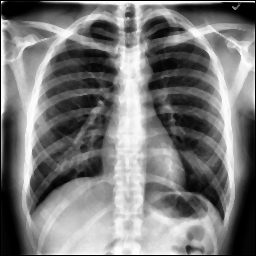

Number of features = 26


array([ 5.12448422e+03,  6.19378525e+01,  2.75159493e-04,  4.70816218e+03,
        1.78543932e+00,  2.42465365e-01,  2.75159493e-04,  5.09875336e+01,
        3.62969756e+01,  1.22503204e+02,  5.58736284e+03,  6.20549284e-03,
       -1.20934252e+00,  5.82973054e-03,  7.65927284e+00,  2.39232225e-02,
        1.28500000e+02,  2.56000000e+02,  3.82057220e+02,  2.39232225e-02,
        1.28500000e+02,  2.00000000e+00,  6.82842708e+00,  2.33137082e+01,
        5.39012092e-01,  1.00000000e+00])

In [ ]:
pre = preprocess_image(normal[0])
cv2_imshow((pre*255).astype('uint8'))
feature1 = feature_extraction((pre*255).astype('uint8'))
feature1 = np.asarray(feature1)
print(f'Number of features = {feature1.shape[0]}')
feature1

# Calling function to preprocess images

In [ ]:
normal = extract_normal(count_normal)
pneumo = extract_normal(count_pneumo)

In [ ]:
normal = np.asarray(normal)
pneumo = np.asarray(pneumo)

In [ ]:
normal.shape , pneumo.shape

((6846, 256, 256, 3), (2379, 256, 256, 3))

In [ ]:
all_images = np.concatenate((normal,pneumo))

In [ ]:
# imagenormal = all_images[:500]
# imagepneumo = pneumo[:500]
# imagenormal = np.asarray(imagenormal)
# imagepneumo = np.asarray(imagepneumo)
# images = np.concatenate((imagenormal,imagepneumo))

In [ ]:
preprocessed_array = []
label = []
for i in range(1500):
  preprocessed1 =  preprocess_image(normal[i])
  preprocessed_array.append(preprocessed1)
  label.append(0)
for i in range(500):
  preprocessed2 =  preprocess_image(pneumo[i])
  preprocessed_array.append(preprocessed2)
  label.append(1)

In [ ]:
label = np.asarray(label)
preprocessed_array = np.asarray(preprocessed_array)
# images = np.asarray(images)

In [ ]:
# images.shape
preprocessed_array.shape , label.shape

((2000, 256, 256), (2000,))

# Calling function to extract features of images

In [ ]:
feature_data = []
for i in range(2000):
  feature_of_1 = feature_extraction((preprocessed_array[i]*255).astype('uint8'))
  feature_data.append(feature_of_1)

In [ ]:
feature_names = ['contrast','dissimilarity','energy','correlation','entropy','homogeneity','angular_second_moment','mean_gabor','standard_gabor','mean',
                                   'variance','skewness','kurtosis','energy_histogram','entropy_histogram','short_run_emphasis','long_run_emphasis','gray_level_nonuniformity',
                                   'run_length_nonuniformity','low_gray_level_run_emphasis','high_gray_level_run_emphasis','area','perimeter','compactness','circularity',
                                   'aspect_ratio']
features = pd.DataFrame(feature_data , columns = feature_names)

In [ ]:
print(features.shape)
print(type(features))

(2000, 26)
<class 'pandas.core.frame.DataFrame'>


In [ ]:
features['label'] = label

In [ ]:
features.shape

(2000, 27)

In [ ]:
features.head()

,contrast,dissimilarity,energy,correlation,entropy,homogeneity,angular_second_moment,mean_gabor,standard_gabor,mean,...,gray_level_nonuniformity,run_length_nonuniformity,low_gray_level_run_emphasis,high_gray_level_run_emphasis,area,perimeter,compactness,circularity,aspect_ratio,label
0,5124.484221,61.937852,0.000275,4708.162183,1.785439,0.242465,0.000275,50.987534,36.296976,122.503204,...,256.0,382.057220,0.023923,128.5,2.0,6.828427,23.313708,0.539012,1.000000,0
1,5256.265364,62.542605,0.000343,4008.617570,1.593537,0.249199,0.000343,48.932800,37.531176,117.118134,...,256.0,700.886108,0.023923,128.5,36993.5,1928.663117,100.551216,0.124975,0.960630,0
2,4485.521968,57.628205,0.000333,5094.721939,1.660227,0.263055,0.000333,49.398117,36.339939,119.186539,...,256.0,698.866669,0.023923,128.5,0.0,0.000000,0.000000,0.000000,1.000000,0
3,5034.793287,60.972445,0.000368,3794.630167,1.635146,0.237169,0.000368,52.326813,36.069619,125.903717,...,256.0,374.841492,0.023923,128.5,46613.0,1676.881371,60.325041,0.208311,1.000000,0
4,5142.937360,61.584035,0.000399,3641.165584,1.460915,0.249929,0.000399,48.809235,35.061676,119.521255,...,256.0,595.455383,0.023923,128.5,35517.0,2034.812393,116.576892,0.107795,0.870079,0


In [ ]:
features.to_csv('features_file')

In [ ]:
features_file = pd.read_csv('features_file')
features_file.head()

,Unnamed: 0,contrast,dissimilarity,energy,correlation,entropy,homogeneity,angular_second_moment,mean_gabor,standard_gabor,...,gray_level_nonuniformity,run_length_nonuniformity,low_gray_level_run_emphasis,high_gray_level_run_emphasis,area,perimeter,compactness,circularity,aspect_ratio,label
0,0,5124.484221,61.937852,0.000275,4708.162183,1.785439,0.242465,0.000275,50.987534,36.296976,...,256.0,382.057220,0.023923,128.5,2.0,6.828427,23.313708,0.539012,1.000000,0
1,1,5256.265364,62.542605,0.000343,4008.617570,1.593537,0.249199,0.000343,48.932800,37.531176,...,256.0,700.886108,0.023923,128.5,36993.5,1928.663117,100.551216,0.124975,0.960630,0
2,2,4485.521968,57.628205,0.000333,5094.721939,1.660227,0.263055,0.000333,49.398117,36.339939,...,256.0,698.866669,0.023923,128.5,0.0,0.000000,0.000000,0.000000,1.000000,0
3,3,5034.793287,60.972445,0.000368,3794.630167,1.635146,0.237169,0.000368,52.326813,36.069619,...,256.0,374.841492,0.023923,128.5,46613.0,1676.881371,60.325041,0.208311,1.000000,0
4,4,5142.937360,61.584035,0.000399,3641.165584,1.460915,0.249929,0.000399,48.809235,35.061676,...,256.0,595.455383,0.023923,128.5,35517.0,2034.812393,116.576892,0.107795,0.870079,0


# CREATING TRAIN AND TEST SETS

In [ ]:
x = features.iloc[:,:26]
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   contrast                      2000 non-null   float64
 1   dissimilarity                 2000 non-null   float64
 2   energy                        2000 non-null   float64
 3   correlation                   2000 non-null   float64
 4   entropy                       2000 non-null   float64
 5   homogeneity                   2000 non-null   float64
 6   angular_second_moment         2000 non-null   float64
 7   mean_gabor                    2000 non-null   float64
 8   standard_gabor                2000 non-null   float64
 9   mean                          2000 non-null   float64
 10  variance                      2000 non-null   float64
 11  skewness                      2000 non-null   float64
 12  kurtosis                      2000 non-null   float64
 13  ene

In [ ]:
y = features['label']
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2000 entries, 0 to 1999
Series name: label
Non-Null Count  Dtype
--------------  -----
2000 non-null   int64
dtypes: int64(1)
memory usage: 15.8 KB


In [ ]:
x_train , x_test , y_train , y_test = tts(x , y , test_size=0.2 , shuffle=True , random_state=42 , stratify=y)

# Scaling / Normalizing the data (features)

In [ ]:
scaler = StandardScaler()
x_train_normal = scaler.fit_transform(x_train)
x_test_normal = scaler.transform(x_test)

# Applying Support Vector Machine (SVM)

In [ ]:
svm_model = SVC(random_state=42 , kernel='rbf' , C=50)
svm_model.fit(x_train_normal , y_train)
y_prediction = svm_model.predict(x_test_normal)

accuracy = accuracy_score(y_prediction , y_test)
print(f'accuracy of model is: {accuracy*100}%')
y_prediction

accuracy of model is: 72.0%


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,

In [ ]:
class SVM:

    def __init__(self, C = 1.0):
        # C = error term
        self.C = C
        self.w = 0
        self.b = 0

    # Hinge Loss Function / Calculation
    def hingeloss(self, w, b, x, y):
        # Regularizer term
        reg = 0.5 * (w * w)

        for i in range(x.shape[0]):
            # Optimization term
            opt_term = y[i] * ((np.dot(w, x[i])) + b)

            # calculating loss
            loss = reg + self.C * max(0, 1-opt_term)
        return loss[0][0]

    def fit(self, X, Y, batch_size=100, learning_rate=0.001, epochs=1000):
        # The number of features in X
        number_of_features = X.shape[1]

        # The number of Samples in X
        number_of_samples = X.shape[0]

        c = self.C

        # Creating ids from 0 to number_of_samples - 1
        ids = np.arange(number_of_samples)

        # Shuffling the samples randomly
        np.random.shuffle(ids)

        # creating an array of zeros
        w = np.zeros((1, number_of_features))
        b = 0
        losses = []

        # Gradient Descent logic
        for i in range(epochs):
            # Calculating the Hinge Loss
            l = self.hingeloss(w, b, X, Y)

            # Appending all losses
            losses.append(l)

            # Starting from 0 to the number of samples with batch_size as interval
            for batch_initial in range(0, number_of_samples, batch_size):
                gradw = 0
                gradb = 0

                for j in range(batch_initial, batch_initial+ batch_size):
                    if j < number_of_samples:
                        x = ids[j]
                        ti = Y[x] * (np.dot(w, X[x].T) + b)

                        if ti > 1:
                            gradw += 0
                            gradb += 0
                        else:
                            # Calculating the gradients

                            #w.r.t w
                            gradw += c * Y[x] * X[x]
                            # w.r.t b
                            gradb += c * Y[x]

                # Updating weights and bias
                w = w - learning_rate * w + learning_rate * gradw
                b = b + learning_rate * gradb

        self.w = w
        self.b = b

        return self.w, self.b, losses

    def predict(self, X):

        prediction = np.dot(X, self.w[0]) + self.b # w.x + b
        return np.sign(prediction)

In [ ]:
# svm = SVM()

# w, b, losses = svm.fit(x_train, y_train)
# prediction = svm.predict(x_test)

# # Loss value
# lss = losses.pop()

# print("Loss:", lss)
# print("Prediction:", prediction)
# print("Accuracy:", accuracy_score(prediction, y_test))
# print("w, b:", [w, b])

KeyError: ignored

In [ ]:
scaled_features = pd.DataFrame(scaler.fit_transform(x))
scaled_features.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.475474,0.588999,-1.153146,0.665306,1.394350,-0.483123,-1.153146,0.199071,0.187538,0.111710,...,0.0,0.0,-0.264753,3.469447e-18,0.0,-1.308309,-1.354837,-0.518413,2.154401,-0.200128
1,0.959203,0.895834,-0.648448,0.221508,0.644171,-0.120039,-0.648448,-0.598691,1.218362,-0.771700,...,0.0,0.0,0.047510,6.938894e-18,0.0,0.633956,0.609502,-0.054145,-0.356167,-0.210510
2,-1.869965,-1.597604,-0.718588,0.910543,0.904876,0.627131,-0.718588,-0.418029,0.223422,-0.432382,...,0.0,0.0,0.045532,3.469447e-18,0.0,-1.308414,-1.361816,-0.658550,-1.113967,-0.200128
3,0.146245,0.099176,-0.458156,0.085752,0.806830,-0.768693,-0.458156,0.719054,-0.002354,0.669557,...,0.0,0.0,-0.271820,6.938894e-18,0.0,1.139034,0.352152,-0.295941,0.149153,-0.200128
4,0.543210,0.409481,-0.226624,-0.011608,0.125731,-0.080671,-0.226624,-0.646666,-0.844204,-0.377473,...,0.0,0.0,-0.055750,3.469447e-18,0.0,0.556431,0.717999,0.042184,-0.460340,-0.234391


<Axes: >

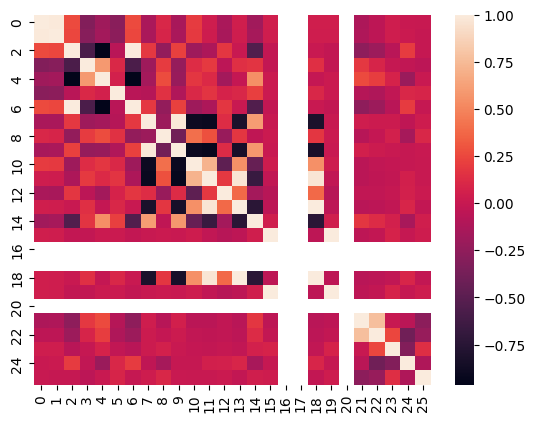

In [ ]:
sns.heatmap(scaled_features.corr())
#lighter shades represent more correlation and vice versa

# Applying Principal Component Analysis (PCA)

In [ ]:
pca = PCA(n_components = 15)  #no. of features needed at end is 20
pca.fit(scaled_features)
features_pca = pca.transform(scaled_features)
features_pca = pd.DataFrame(features_pca)
features_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.392578,-1.102763,-0.197750,-2.230994,-1.493149,2.275782,-0.198102,0.133378,0.690119,0.698409,-0.674538,-0.613146,0.018339,0.182716,0.025784
1,1.340343,-1.218767,-2.063814,0.161442,-0.324920,-0.221101,0.520990,-0.431096,-0.242181,0.142890,-0.087726,0.056199,-0.063889,-0.067466,0.123875
2,0.706387,-1.852666,1.705938,-1.873525,0.201271,-0.831080,-1.110272,-0.788907,0.479583,-1.288983,0.399860,0.271881,-0.043342,0.299331,0.130670
3,-1.253864,-0.941364,-0.116265,0.943850,-0.467688,1.076307,0.021221,-0.331973,-0.463380,0.332187,-0.423181,0.340513,0.135974,0.222914,0.060624
4,0.510577,-0.402118,-1.050781,0.819157,-0.368043,-0.307371,-0.177047,0.864024,-0.087714,-0.554181,0.452714,-0.014179,-0.190487,-0.066197,0.154393


<Axes: >

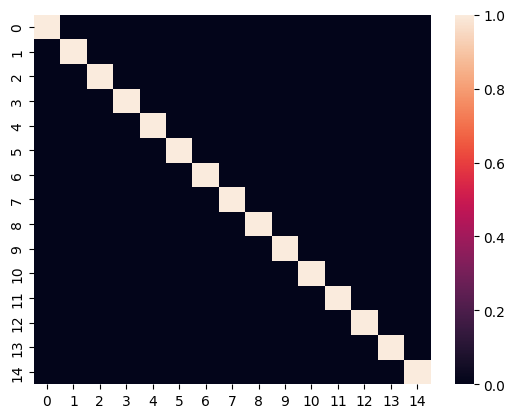

In [ ]:
sns.heatmap(features_pca.corr())

In [ ]:
x_train_pca , x_test_pca , y_train_pca , y_test_pca = tts(features_pca , y , test_size=0.2 , shuffle=True , random_state=42 , stratify=y)

In [ ]:
svm_model.fit(x_train_pca , y_train_pca)
y_prediction_pca = svm_model.predict(x_test_pca)

accuracy_pca = accuracy_score(y_prediction_pca , y_test_pca)
print(f'accuracy of model is: {accuracy_pca*100}%')

accuracy of model is: 72.0%


# Finding Precision, Recall, F1_score and Support

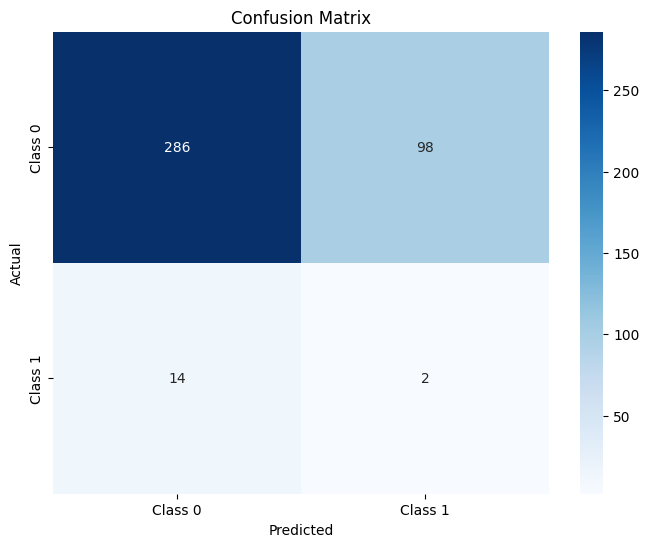

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_prediction_pca , y_test_pca)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def calculate_metrics(conf_matrix):
    TP = conf_matrix[0][0]  # True Positives
    TN = conf_matrix[1][1]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1_score

In [ ]:
accuracy, precision, recall, f1_score = calculate_metrics(conf_matrix)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.72
Precision: 0.7447916666666666
Recall: 0.9533333333333334
F1 Score: 0.8362573099415204


# Saving file

In [ ]:
path_for_saving = '/content/drive/MyDrive/classifier_data/'

In [ ]:
pickle_out = open(path_for_saving + "pca.pickle" , "wb")
pickle.dump(pca , pickle_out)
pickle_out.close()

In [ ]:
pickle_out = open(path_for_saving + "scaler.pickle" , "wb")
pickle.dump(scaler , pickle_out)
pickle_out.close()

In [ ]:
pickle_out = open(path_for_saving + "svm.pickle" , "wb")
pickle.dump(svm_model , pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open(path_for_saving + "svm.pickle" , "rb")
svm = pickle.load(pickle_in)

In [ ]:
pickle_in = open(path_for_saving + "pca.pickle" , "rb")
pca = pickle.load(pickle_in)

In [ ]:
pickle_in = open(path_for_saving + "scaler.pickle" , "rb")
scaler = pickle.load(pickle_in)

In [ ]:
new_pred = svm.predict(x_test_pca)
new_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,

In [ ]:
print(accuracy_score(y_test_pca , new_pred)*100)

72.0


In [ ]:
s1 = preprocess_image(all_images[567])
s2 = feature_extraction((s1*255).astype('uint8'))

In [ ]:
s2 = np.asarray(s2)
s2.reshape(1,-1)
s2.shape

(26,)

In [ ]:
s2 = np.asarray(s2)
s2 = s2.reshape(1,-1)
s2 = scaler.transform(s2)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
feature_names = ['contrast','dissimilarity','energy','correlation','entropy','homogeneity','angular_second_moment','mean_gabor','standard_gabor','mean',
                                   'variance','skewness','kurtosis','energy_histogram','entropy_histogram','short_run_emphasis','long_run_emphasis','gray_level_nonuniformity',
                                   'run_length_nonuniformity','low_gray_level_run_emphasis','high_gray_level_run_emphasis','area','perimeter','compactness','circularity',
                                   'aspect_ratio']
s2 = pd.DataFrame(s2 , columns = feature_names)

In [ ]:
s2 = pd.DataFrame(pca.transform(s2))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [ ]:
predict1 = svm.predict(s2)
if predict1==[0]:
  result = "negative"
else:
  result = "positive"

In [ ]:
print("This x-ray scan is :",result)

This x-ray scan is : negative


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/classifier_data/features_file")

In [ ]:
data['label'][567]

0